# Make Dataset

In [6]:
import pandas as pd

# Load the dataset from the original CSV file
original_df = pd.read_csv('dataset_train.csv')

# Randomly select 2000 rows from the anchor and positive columns where label is 1
positive_samples = original_df.sample(n=2000)[['Anchor', 'Positive']]
positive_samples['label'] = 1

# Exclude the selected positive samples from the original dataset
remaining_df = original_df.drop(positive_samples.index)

# Randomly select 2000 rows from the remaining anchor and negative columns where label is 0
negative_samples = remaining_df.sample(n=2000)[['Anchor', 'Negative']]
negative_samples['label'] = 0

# Merge the 'Negative' and 'Positive' columns into a new column 'Merged'
positive_samples['Merged'] = positive_samples['Positive']
negative_samples['Merged'] = negative_samples['Negative']

# Concatenate the positive and negative samples into a new DataFrame
final_df = pd.concat([positive_samples[['Anchor', 'Merged', 'label']], negative_samples[['Anchor', 'Merged', 'label']]])

# Save the final DataFrame to a new CSV file
final_df.to_csv('contrastive_dataset.csv', index=False)


In [7]:
# Rename columns
final_df.columns = ['Positive', 'Negative', 'Label']

# Save to CSV
final_df.to_csv('contrastive_dataset.csv', index=False)

# Libraries

In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import os
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

/root/miniconda3/envs/torch2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Dataset

In [4]:
df = pd.read_csv('contrastive_dataset.csv')
df.head(n=5)

,Positive,Negative,Label
0,0421_c5s1_104173_02.jpg,0421_c5s1_103748_01.jpg,1
1,0076_c3s1_018601_01.jpg,0076_c1s1_018376_02.jpg,1
2,1400_c3s3_056053_01.jpg,1400_c3s3_056028_01.jpg,1
3,0843_c2s2_104707_07.jpg,0843_c2s2_104907_04.jpg,1
4,0437_c3s1_128433_01.jpg,0437_c3s1_107067_01.jpg,1


In [5]:
image_dir = "Homework5_dataset/"

# Example

In [5]:
row = df.iloc[2000]

# Read images using PIL
P_img = Image.open(image_dir + row['Positive'])
N_img = Image.open(image_dir + row['Negative'])

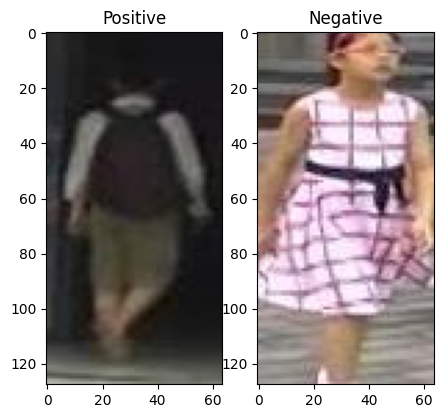

In [18]:
fig, (ax2, ax3) = plt.subplots(1, 2, figsize = (5,5))

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [23]:
row = df.iloc[0]

# Read images using PIL
P_img = Image.open(image_dir + row['Positive'])
N_img = Image.open(image_dir + row['Negative'])

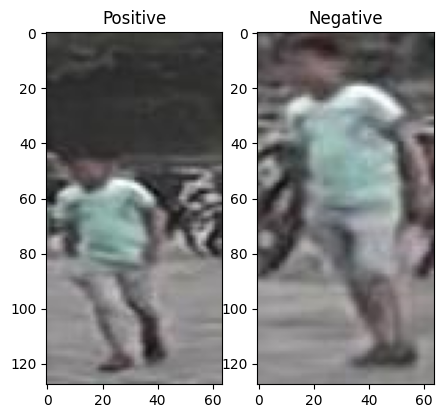

In [24]:
fig, (ax2, ax3) = plt.subplots(1, 2, figsize = (5,5))

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

# Dataset split

In [6]:
# Define a custom dataset
class ImagePairsDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name1 = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        img_name2 = os.path.join(self.root_dir, self.dataframe.iloc[idx, 1])
        label = self.dataframe.iloc[idx, 2]

        image1 = Image.open(img_name1)
        image2 = Image.open(img_name2)

        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)

        return (image1, image2), label

# Normalizing

In [7]:
# Data Transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Splitting the dataset
train_df, val_df = train_test_split(df, test_size=0.2)

In [8]:
# Creating dataset loaders
train_dataset = ImagePairsDataset(dataframe=train_df, root_dir='Homework5_dataset/', transform=transform)
val_dataset = ImagePairsDataset(dataframe=val_df, root_dir='Homework5_dataset/', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True , num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False , num_workers=0)

In [9]:
# Model Definition
class ConsModel(nn.Module):
    def __init__(self, emb_size=512):
        super(ConsModel, self).__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        in_features = self.efficientnet.classifier[-1].in_features
        self.efficientnet.classifier[-1] = nn.Linear(in_features, emb_size)
    
    def forward(self, images):
        embeddings = self.efficientnet(images)
        return embeddings
    
model = ConsModel()
model.to("cuda:1") 
print("Model Loaded")

Model Loaded


/root/miniconda3/envs/torch2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/torch2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Contrastive Loss

In [10]:
# Contrastive Loss Function
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [11]:
# Loss and Optimizer
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning Rate Scheduler
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

# Device configuration
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')


In [15]:
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

# Validation function
def validate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for ((data1, data2), labels) in val_loader:
            data1, data2, labels = data1.to(device), data2.to(device), labels.to(device)
            output1 = model(data1)
            output2 = model(data2)
            loss = criterion(output1, output2, labels)
            val_loss += loss.item()
    return val_loss / len(val_loader)

def train(model, device, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs, save_path='best_model.pth'):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch_idx, ((data1, data2), labels) in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}"):
            data1, data2, labels = data1.to(device), data2.to(device), labels.to(device)
            optimizer.zero_grad()
            output1 = model(data1)
            output2 = model(data2)
            loss = criterion(output1, output2, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        scheduler.step()  # Update learning rate
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = validate(model, device, val_loader, criterion)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

        # Save the model if the validation loss has decreased
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)
            print(f'Saving model with the best validation loss: {best_val_loss}')

    # Plotting
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


Epoch 1/20: 100%|██████████| 100/100 [00:21<00:00,  4.68it/s]


Epoch 1, Training Loss: 0.2511007668077946, Validation Loss: 0.3005025345087051
Saving model with the best validation loss: 0.3005025345087051


Epoch 2/20: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


Epoch 2, Training Loss: 0.24397246554493904, Validation Loss: 0.30448806583881377


Epoch 3/20: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


Epoch 3, Training Loss: 0.2398535792529583, Validation Loss: 0.30193488955497744


Epoch 4/20: 100%|██████████| 100/100 [00:20<00:00,  4.89it/s]


Epoch 4, Training Loss: 0.23690853014588356, Validation Loss: 0.30194384753704073


Epoch 5/20: 100%|██████████| 100/100 [00:21<00:00,  4.75it/s]


Epoch 5, Training Loss: 0.2334325172007084, Validation Loss: 0.3003033471107483
Saving model with the best validation loss: 0.3003033471107483


Epoch 6/20: 100%|██████████| 100/100 [00:21<00:00,  4.76it/s]


Epoch 6, Training Loss: 0.23446728363633157, Validation Loss: 0.3002366238832474
Saving model with the best validation loss: 0.3002366238832474


Epoch 7/20: 100%|██████████| 100/100 [00:20<00:00,  4.78it/s]


Epoch 7, Training Loss: 0.23339468479156494, Validation Loss: 0.2996623748540878
Saving model with the best validation loss: 0.2996623748540878


Epoch 8/20: 100%|██████████| 100/100 [00:21<00:00,  4.75it/s]


Epoch 8, Training Loss: 0.23259404346346854, Validation Loss: 0.2996666532754898


Epoch 9/20: 100%|██████████| 100/100 [00:20<00:00,  4.81it/s]


Epoch 9, Training Loss: 0.23319371327757835, Validation Loss: 0.29979214191436765


Epoch 10/20: 100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


Epoch 10, Training Loss: 0.23426717460155488, Validation Loss: 0.30000230491161345


Epoch 11/20: 100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


Epoch 11, Training Loss: 0.23380908772349357, Validation Loss: 0.2992091691493988
Saving model with the best validation loss: 0.2992091691493988


Epoch 12/20: 100%|██████████| 100/100 [00:20<00:00,  4.96it/s]


Epoch 12, Training Loss: 0.23378339871764184, Validation Loss: 0.29963396072387694


Epoch 13/20: 100%|██████████| 100/100 [00:20<00:00,  4.89it/s]


Epoch 13, Training Loss: 0.2329148058593273, Validation Loss: 0.30021804332733154


Epoch 14/20: 100%|██████████| 100/100 [00:20<00:00,  4.78it/s]


Epoch 14, Training Loss: 0.23542451098561287, Validation Loss: 0.3001172775030136


Epoch 15/20: 100%|██████████| 100/100 [00:21<00:00,  4.55it/s]


Epoch 15, Training Loss: 0.23447398379445075, Validation Loss: 0.3000220799446106


Epoch 16/20: 100%|██████████| 100/100 [00:21<00:00,  4.57it/s]


Epoch 16, Training Loss: 0.2325492288172245, Validation Loss: 0.3000197786092758


Epoch 17/20: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


Epoch 17, Training Loss: 0.2335785734653473, Validation Loss: 0.2992582505941391


Epoch 18/20: 100%|██████████| 100/100 [00:20<00:00,  4.89it/s]


Epoch 18, Training Loss: 0.2332548989355564, Validation Loss: 0.2998683041334152


Epoch 19/20: 100%|██████████| 100/100 [00:20<00:00,  4.92it/s]


Epoch 19, Training Loss: 0.2337953668832779, Validation Loss: 0.2996374225616455


Epoch 20/20: 100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


Epoch 20, Training Loss: 0.23306871265172957, Validation Loss: 0.2991009986400604
Saving model with the best validation loss: 0.2991009986400604


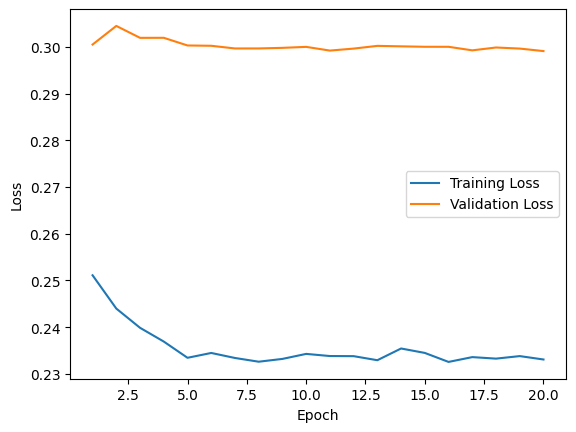

In [16]:
train(model, device, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=20,save_path='best_model_cont.pth')

# AUC

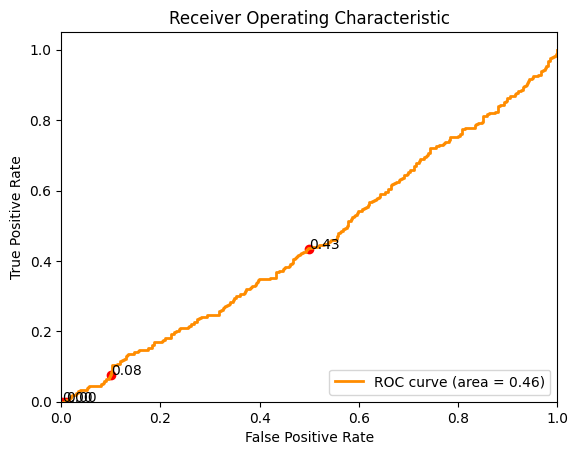

In [17]:
# Assuming you have a function to compute embeddings
def compute_embeddings(loader, model, device):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for (data1, data2), label in loader:
            data1, data2 = data1.to(device), data2.to(device)
            emb1, emb2 = model(data1), model(data2)
            embeddings.append((emb1, emb2))
            labels.append(label)
    return embeddings, labels

# Calculate Euclidean distances and labels
embeddings, labels = compute_embeddings(val_loader, model, device)
distances = [torch.norm(e1 - e2, dim=1).cpu().numpy() for e1, e2 in embeddings]
labels = np.concatenate(labels)

# Flatten distance array
distances = np.concatenate(distances)

# ROC Curve
fpr, tpr, thresholds = roc_curve(labels, distances)
roc_auc = auc(fpr, tpr)

# Find the TPR for specific FPR values
desired_fprs = [0.5, 0.1, 0.01 , 0.001]
tpr_at_desired_fpr = [tpr[np.argmin(np.abs(fpr - desired_fpr))] for desired_fpr in desired_fprs]

# Plotting
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.scatter(desired_fprs, tpr_at_desired_fpr, color='red')
for i, txt in enumerate(tpr_at_desired_fpr):
    plt.annotate(f'{txt:.2f}', (desired_fprs[i], txt))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [33]:
model.load_state_dict(torch.load("best_model_triplet.pt"))
print("Model Loaded")

Model Loaded


In [34]:
def euclidean_dist(img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc - anc_enc_arr).T))
    return dist

In [35]:
import numpy as np
import pandas as pd
from skimage import io
import torch
from tqdm import tqdm
from PIL import Image  # Import Image from PIL

data_dir = "Homework5_dataset/"  
df = pd.read_csv("contrastive_dataset.csv")  

anc_img_names = df["Positive"].tolist()
anc_img_names_arr = np.array(anc_img_names)
encodings = []

model.eval()
with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
        # Using PIL to read the image
        A = Image.open(data_dir + i)
        A = np.array(A)  # Convert PIL image to NumPy array
        A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
        A = A.to("cuda:1")
        A_enc = model(A.unsqueeze(0)) 
        encodings.append(A_enc.squeeze().cpu().detach().numpy())

encodings = np.array(encodings)
encodings_df = pd.DataFrame(encodings)
df_enc = pd.concat([pd.Series(anc_img_names, name="Positive"), encodings_df], axis=1)

df_enc.to_csv("output_cons.csv", index=False)

100%|██████████| 4000/4000 [00:16<00:00, 237.88it/s]


In [36]:
df_enc = pd.read_csv('output_cons.csv')

In [37]:
import numpy as np
import torch
from skimage import io

def process_image(idx, df_enc, model, data_dir):
    img_name = df_enc["Positive"].iloc[idx]
    img_path = data_dir + img_name

    img = io.imread(img_path)
    img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

    model.eval()
    with torch.no_grad():
        img = img.to("cuda:1")
        img_enc = model(img.unsqueeze(0))
        img_enc = img_enc.detach().cpu().numpy()

    anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
    anc_img_names = df_enc["Positive"]

    distance = []

    for i in range(anc_enc_arr.shape[0]):
        dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
        distance = np.append(distance, dist)

    closest_idx = np.argsort(distance)

    return anc_img_names, data_dir, img, img_path, closest_idx, distance


In [38]:
import networkx as nx 
import matplotlib.pyplot as plt
from PIL import Image  

def load_image(image_path):
    # Use PIL to open the image
    image = Image.open(image_path)
    return image

def create_graph(anc_img_names, DATA_DIR, img_path, closest_idx, distance, no_of_closest=10):
    G = nx.Graph()

    S_name = [img_path.split('/')[-1]]

    for s in range(no_of_closest):
        S_name.append(anc_img_names.iloc[closest_idx[s]])

    for i, img_name in enumerate(S_name):
        image = load_image(DATA_DIR + img_name)
        G.add_node(i, image=image)

    for j in range(1, no_of_closest + 1):
        G.add_edge(0, j, weight=distance[closest_idx[j - 1]])

    return G, S_name


def plot_graph(G, S_name):
    pos = nx.kamada_kawai_layout(G)

    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_aspect('equal')
    nx.draw_networkx_edges(G, pos, ax=ax)

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)

    trans = ax.transData.transform
    trans2 = fig.transFigure.inverted().transform

    piesize = 0.1  # this is the image size
    p2 = piesize / 2.0
    for n in G:
        xx, yy = trans(pos[n])  # figure coordinates
        xa, ya = trans2((xx, yy))  # axes coordinates
        a = plt.axes([xa - p2, ya - p2, piesize, piesize])
        a.set_aspect('equal')
        a.imshow(G.nodes[n]['image'])
        a.set_title(S_name[n][0:4])
        a.axis('off')

    ax.axis('off')
    plt.show()


def plot_closest_imgs(anc_img_names, DATA_DIR, img_path, closest_idx, distance, no_of_closest=10):
    G, S_name = create_graph(anc_img_names, DATA_DIR, img_path, closest_idx, distance, no_of_closest)
    plot_graph(G, S_name)

In [42]:
result = process_image(12, df_enc, model, data_dir)
anc_img_names, data_dir, img, img_path, closest_idx, distance = result

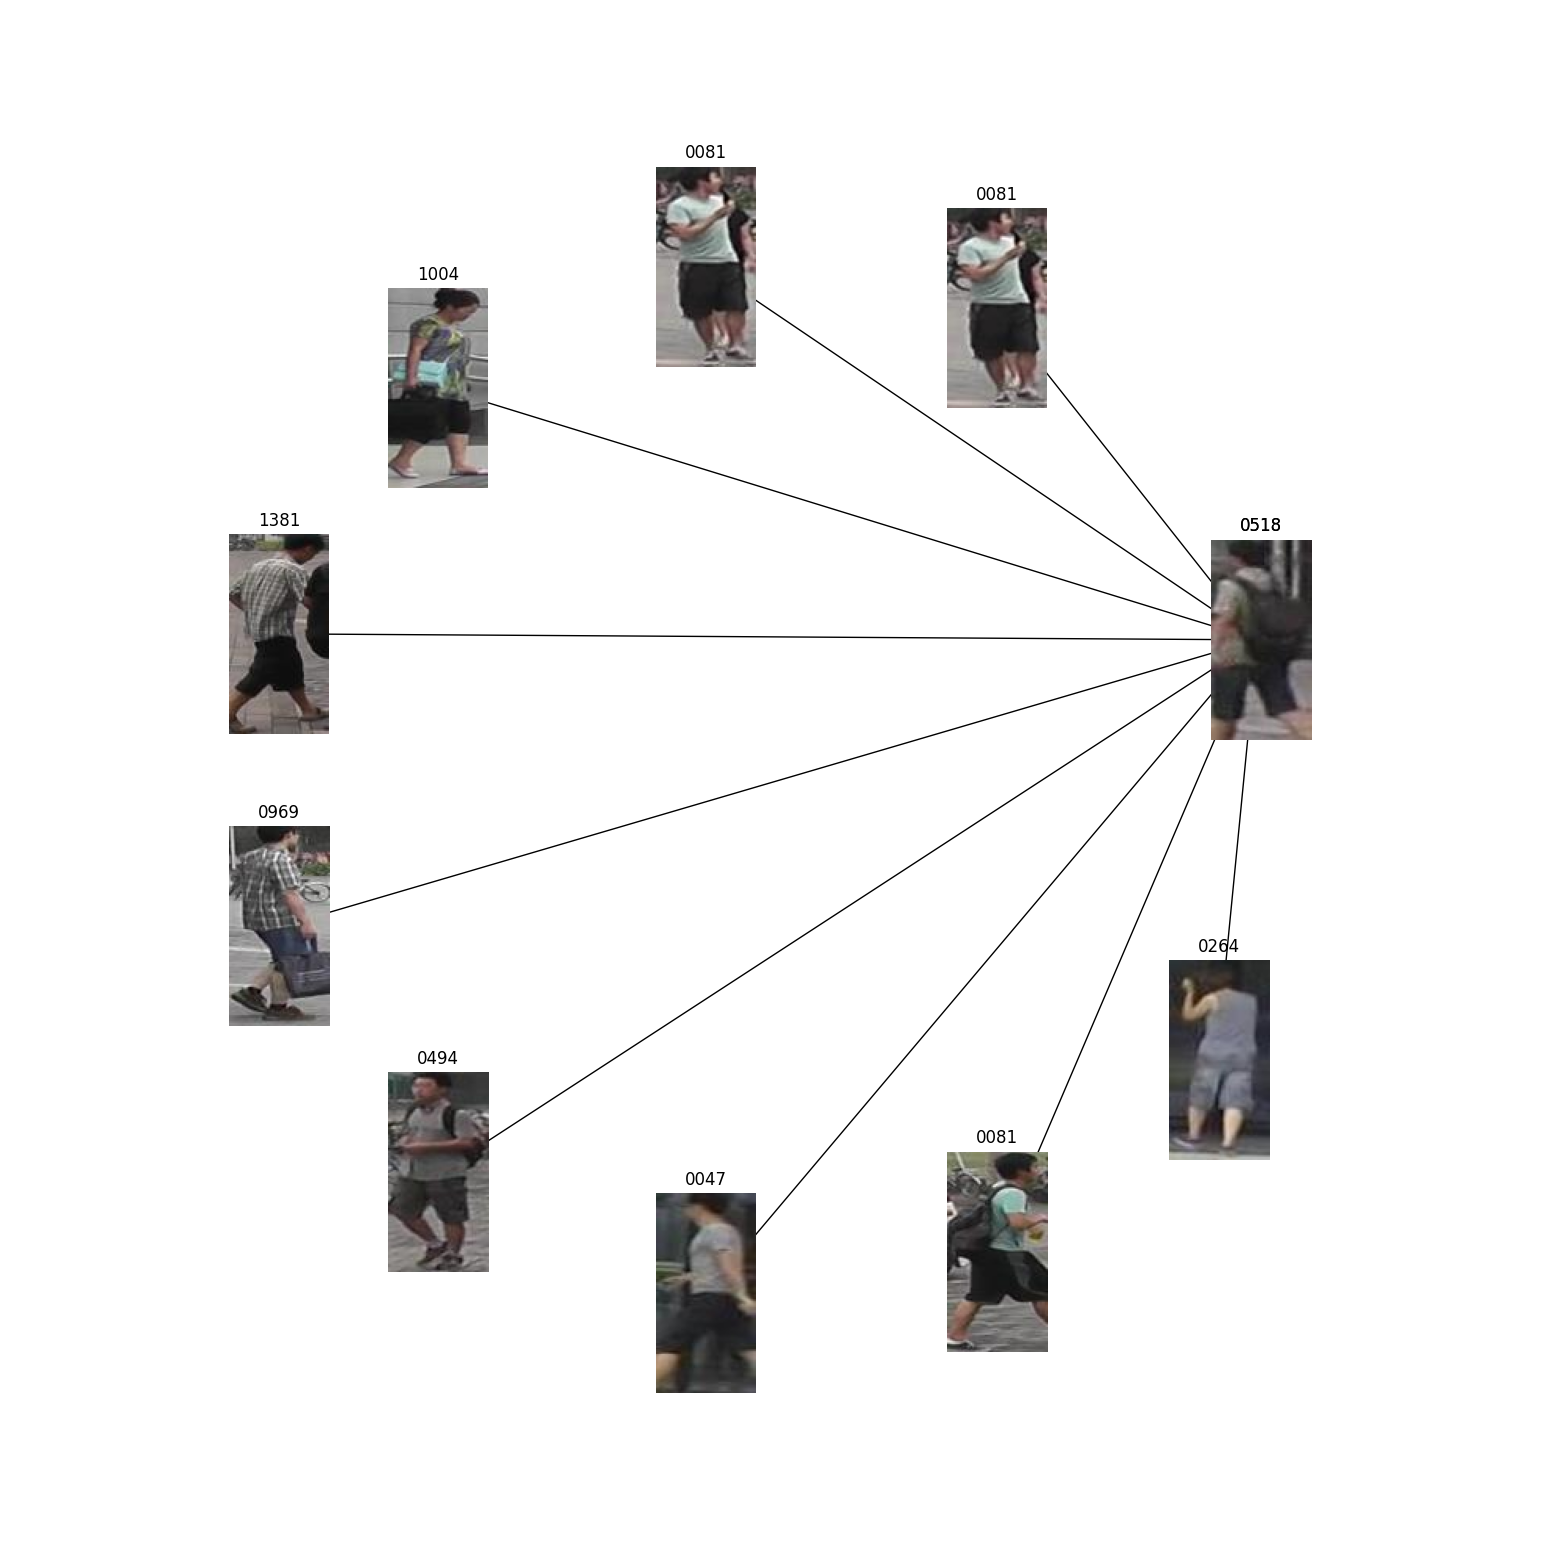

In [43]:
plot_closest_imgs(anc_img_names, data_dir, img_path, closest_idx, distance, no_of_closest=10)


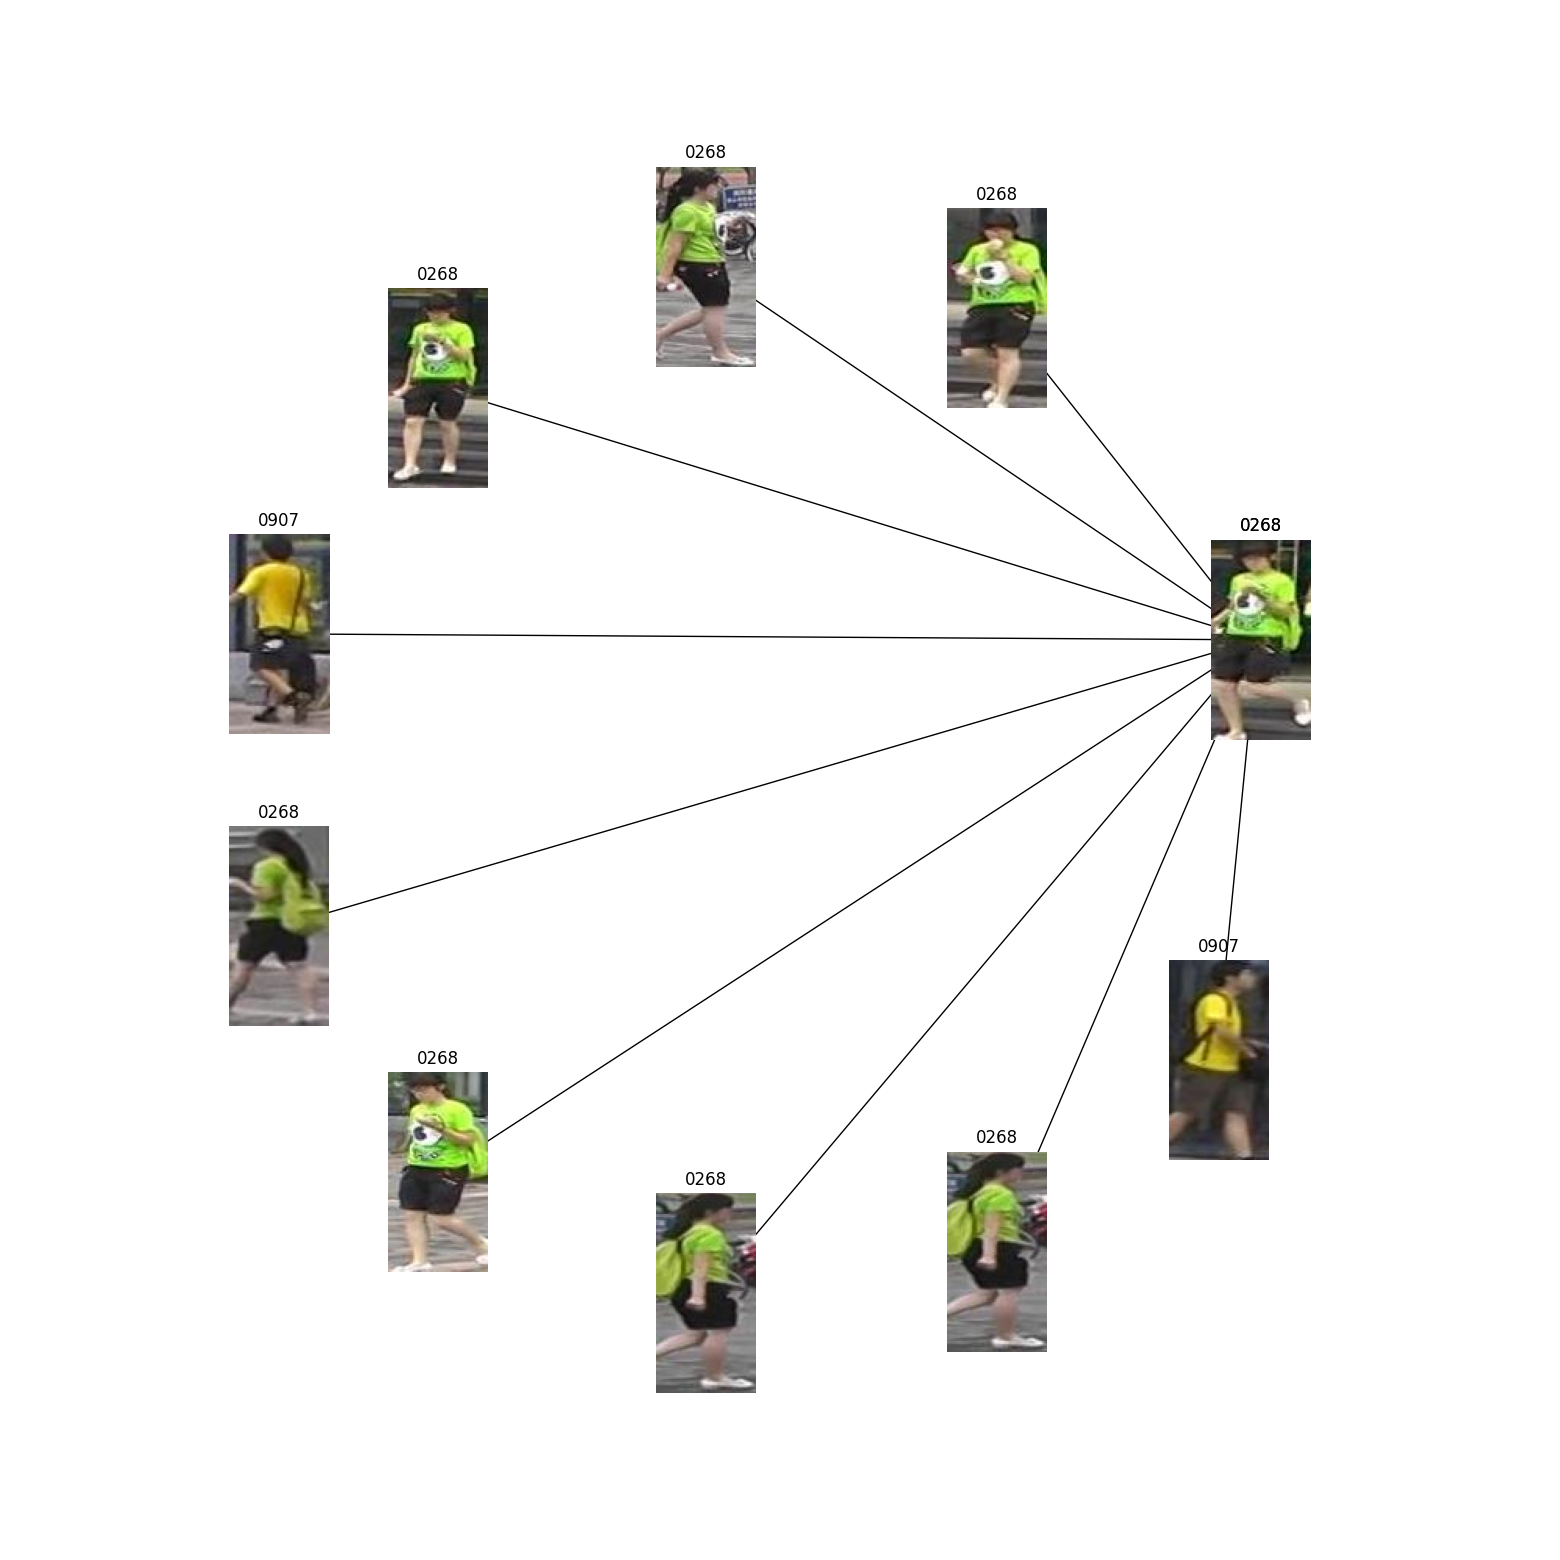

In [44]:
result = process_image(15, df_enc, model, data_dir)
anc_img_names, data_dir, img, img_path, closest_idx, distance = result
plot_closest_imgs(anc_img_names, data_dir, img_path, closest_idx, distance, no_of_closest=10)


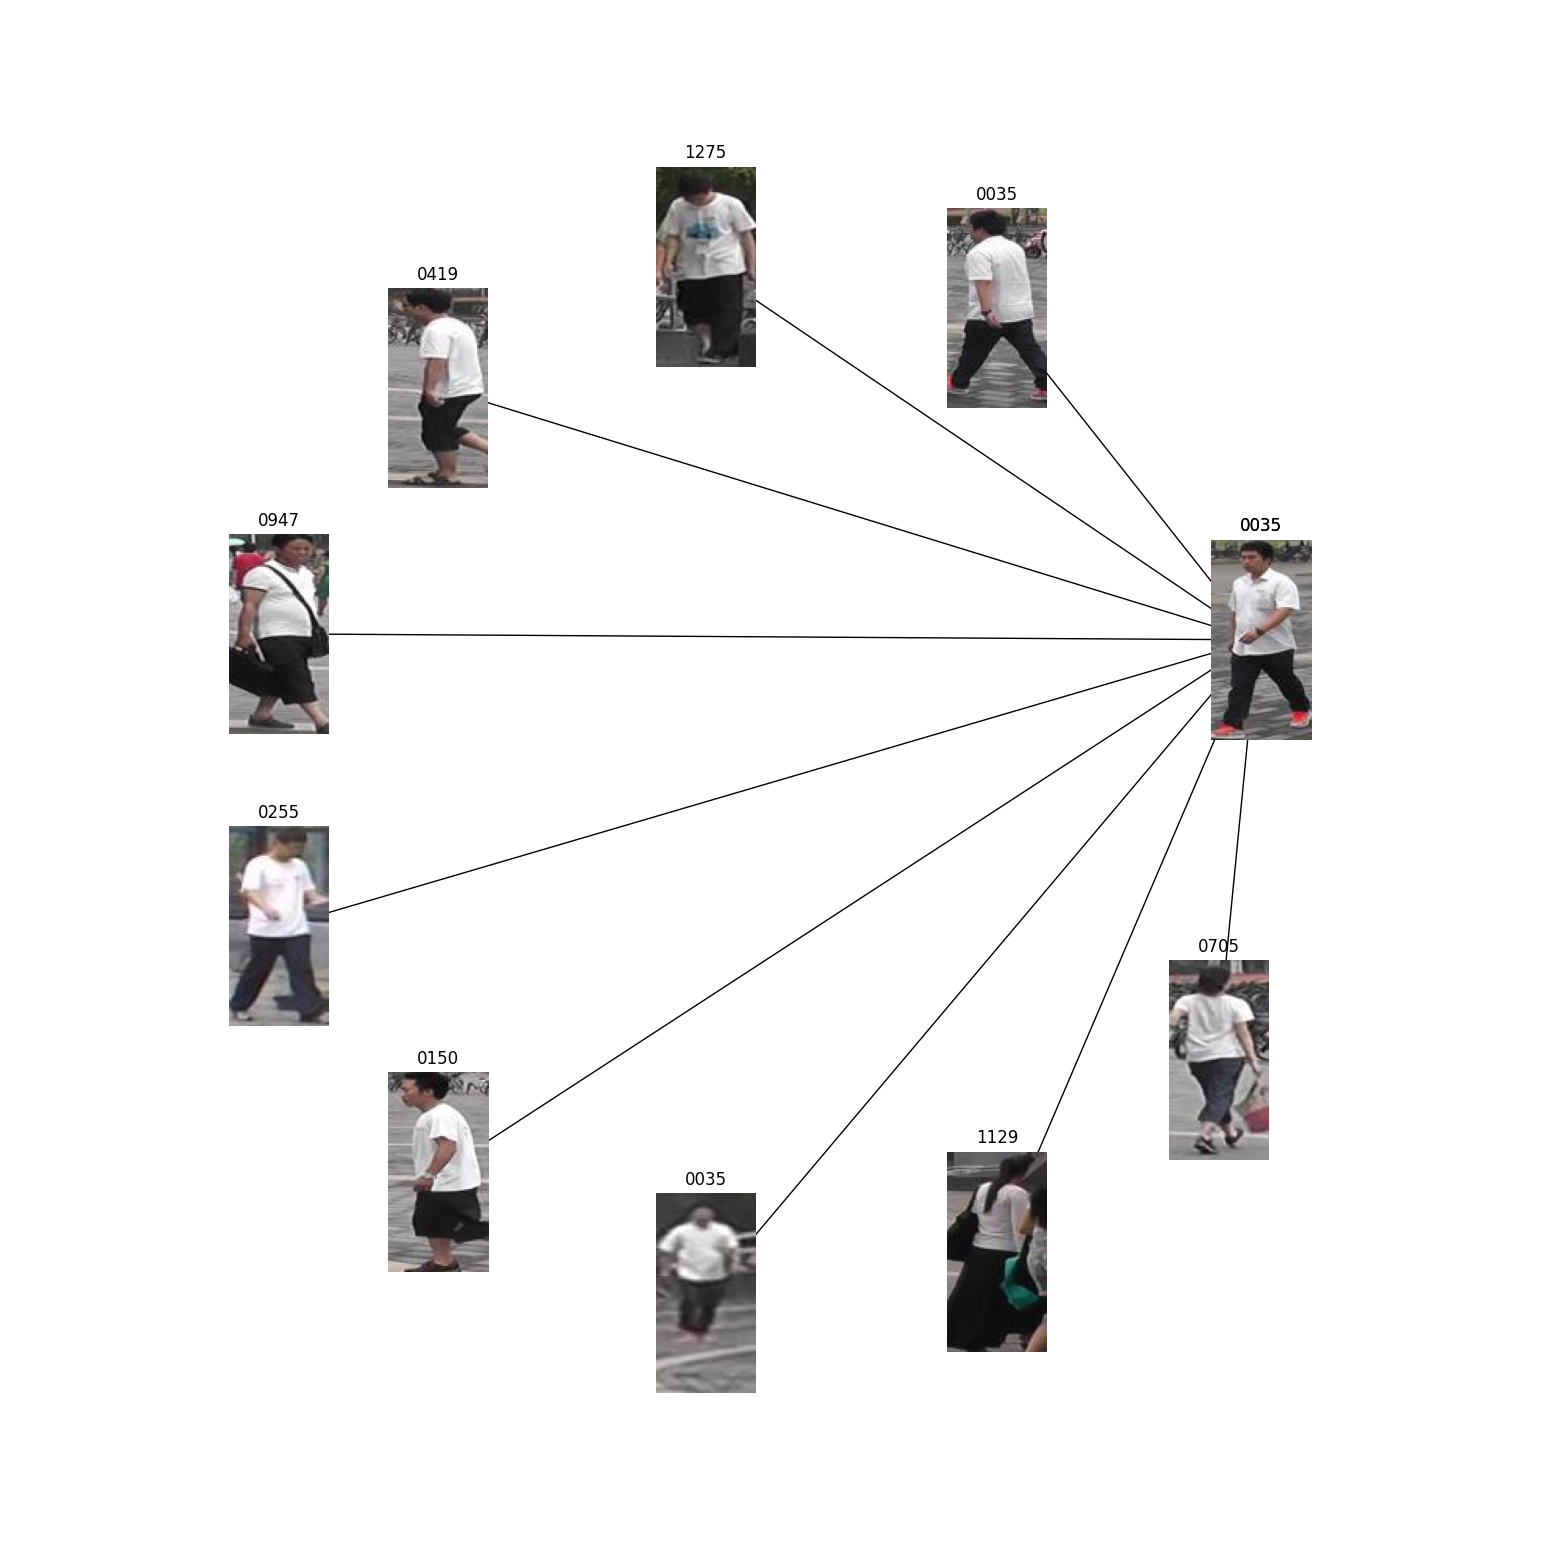

In [45]:
result = process_image(21, df_enc, model, data_dir)
anc_img_names, data_dir, img, img_path, closest_idx, distance = result
plot_closest_imgs(anc_img_names, data_dir, img_path, closest_idx, distance, no_of_closest=10)


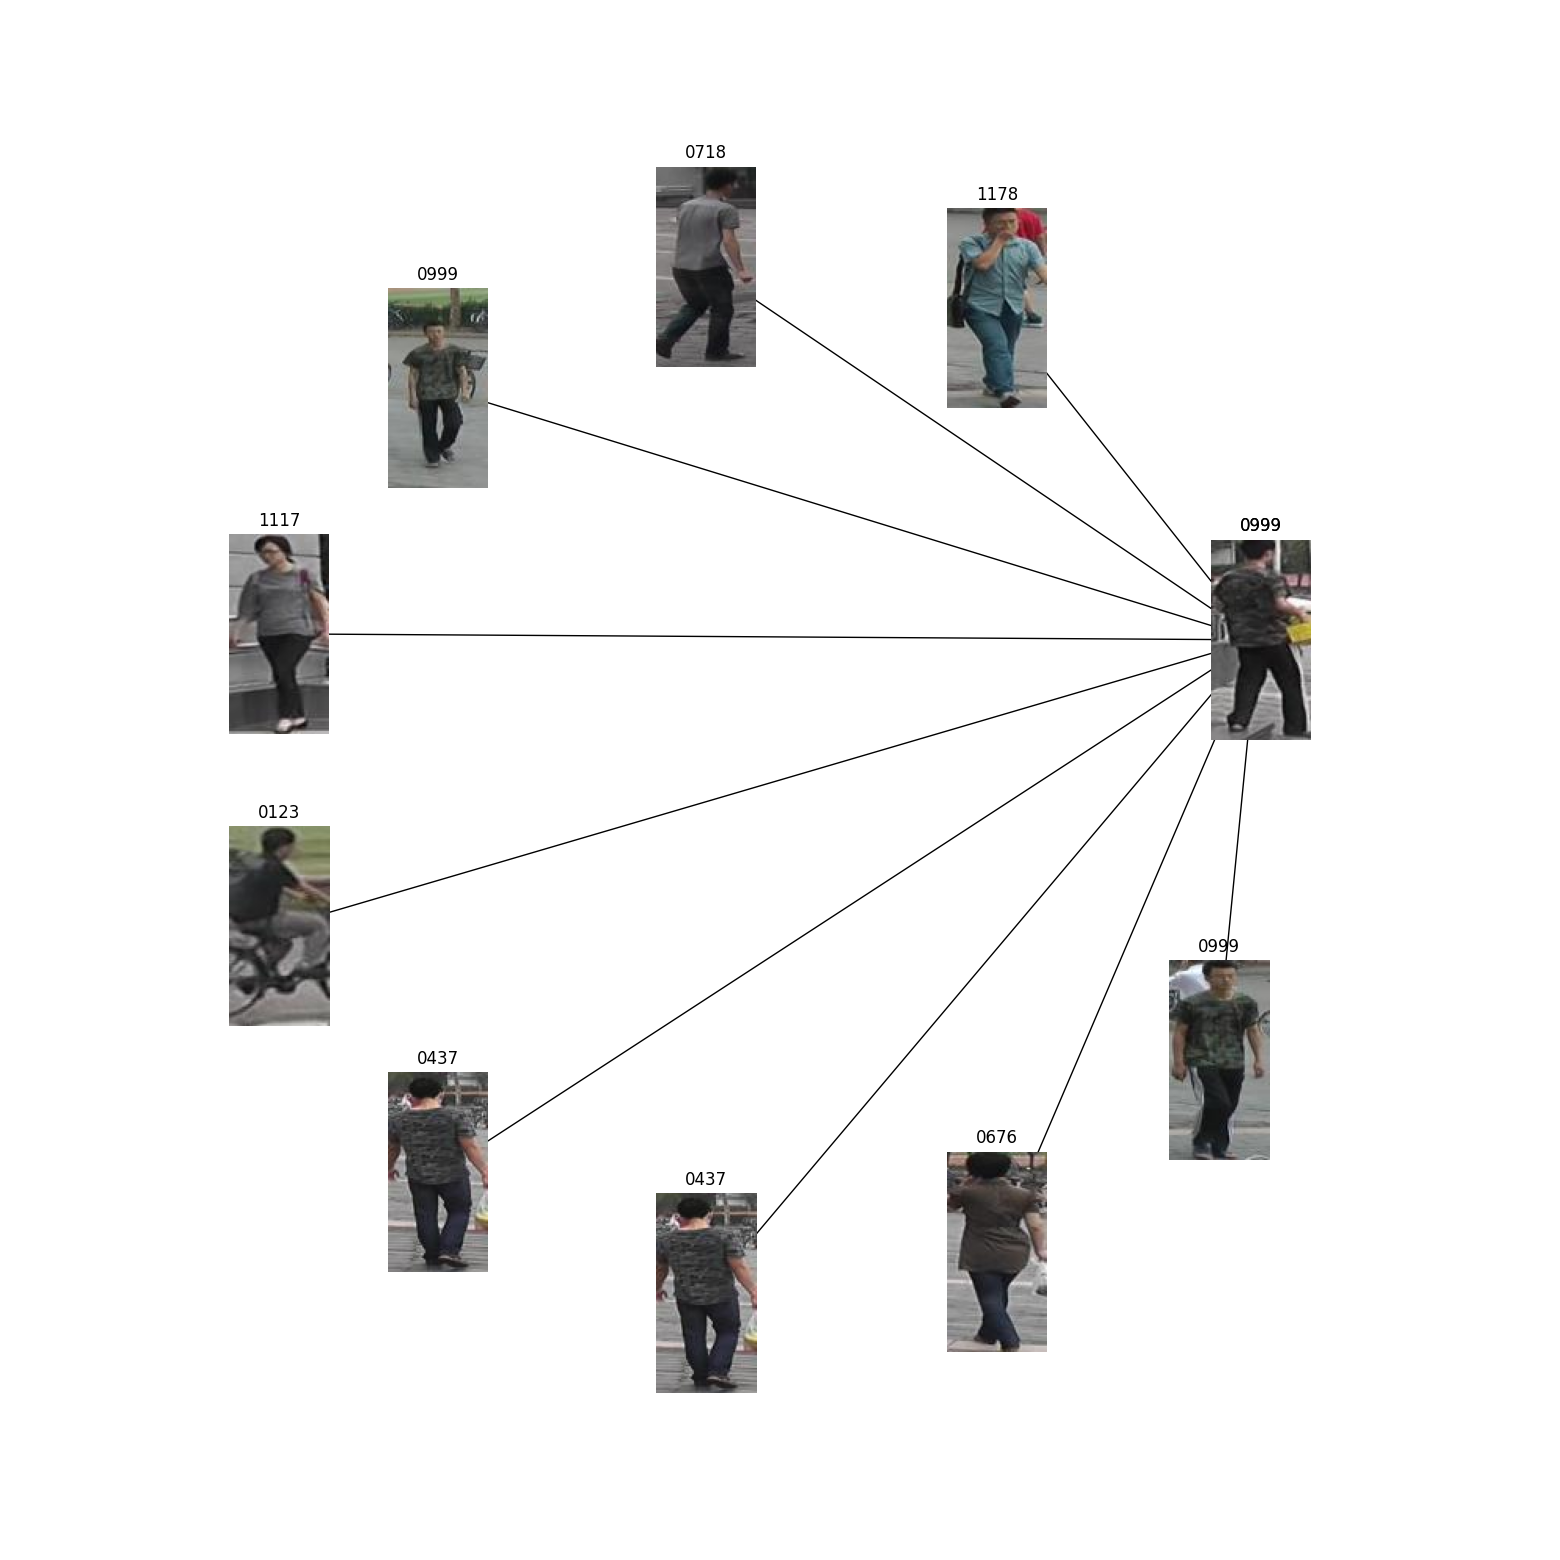

In [46]:
result = process_image(23, df_enc, model, data_dir)
anc_img_names, data_dir, img, img_path, closest_idx, distance = result
plot_closest_imgs(anc_img_names, data_dir, img_path, closest_idx, distance, no_of_closest=10)


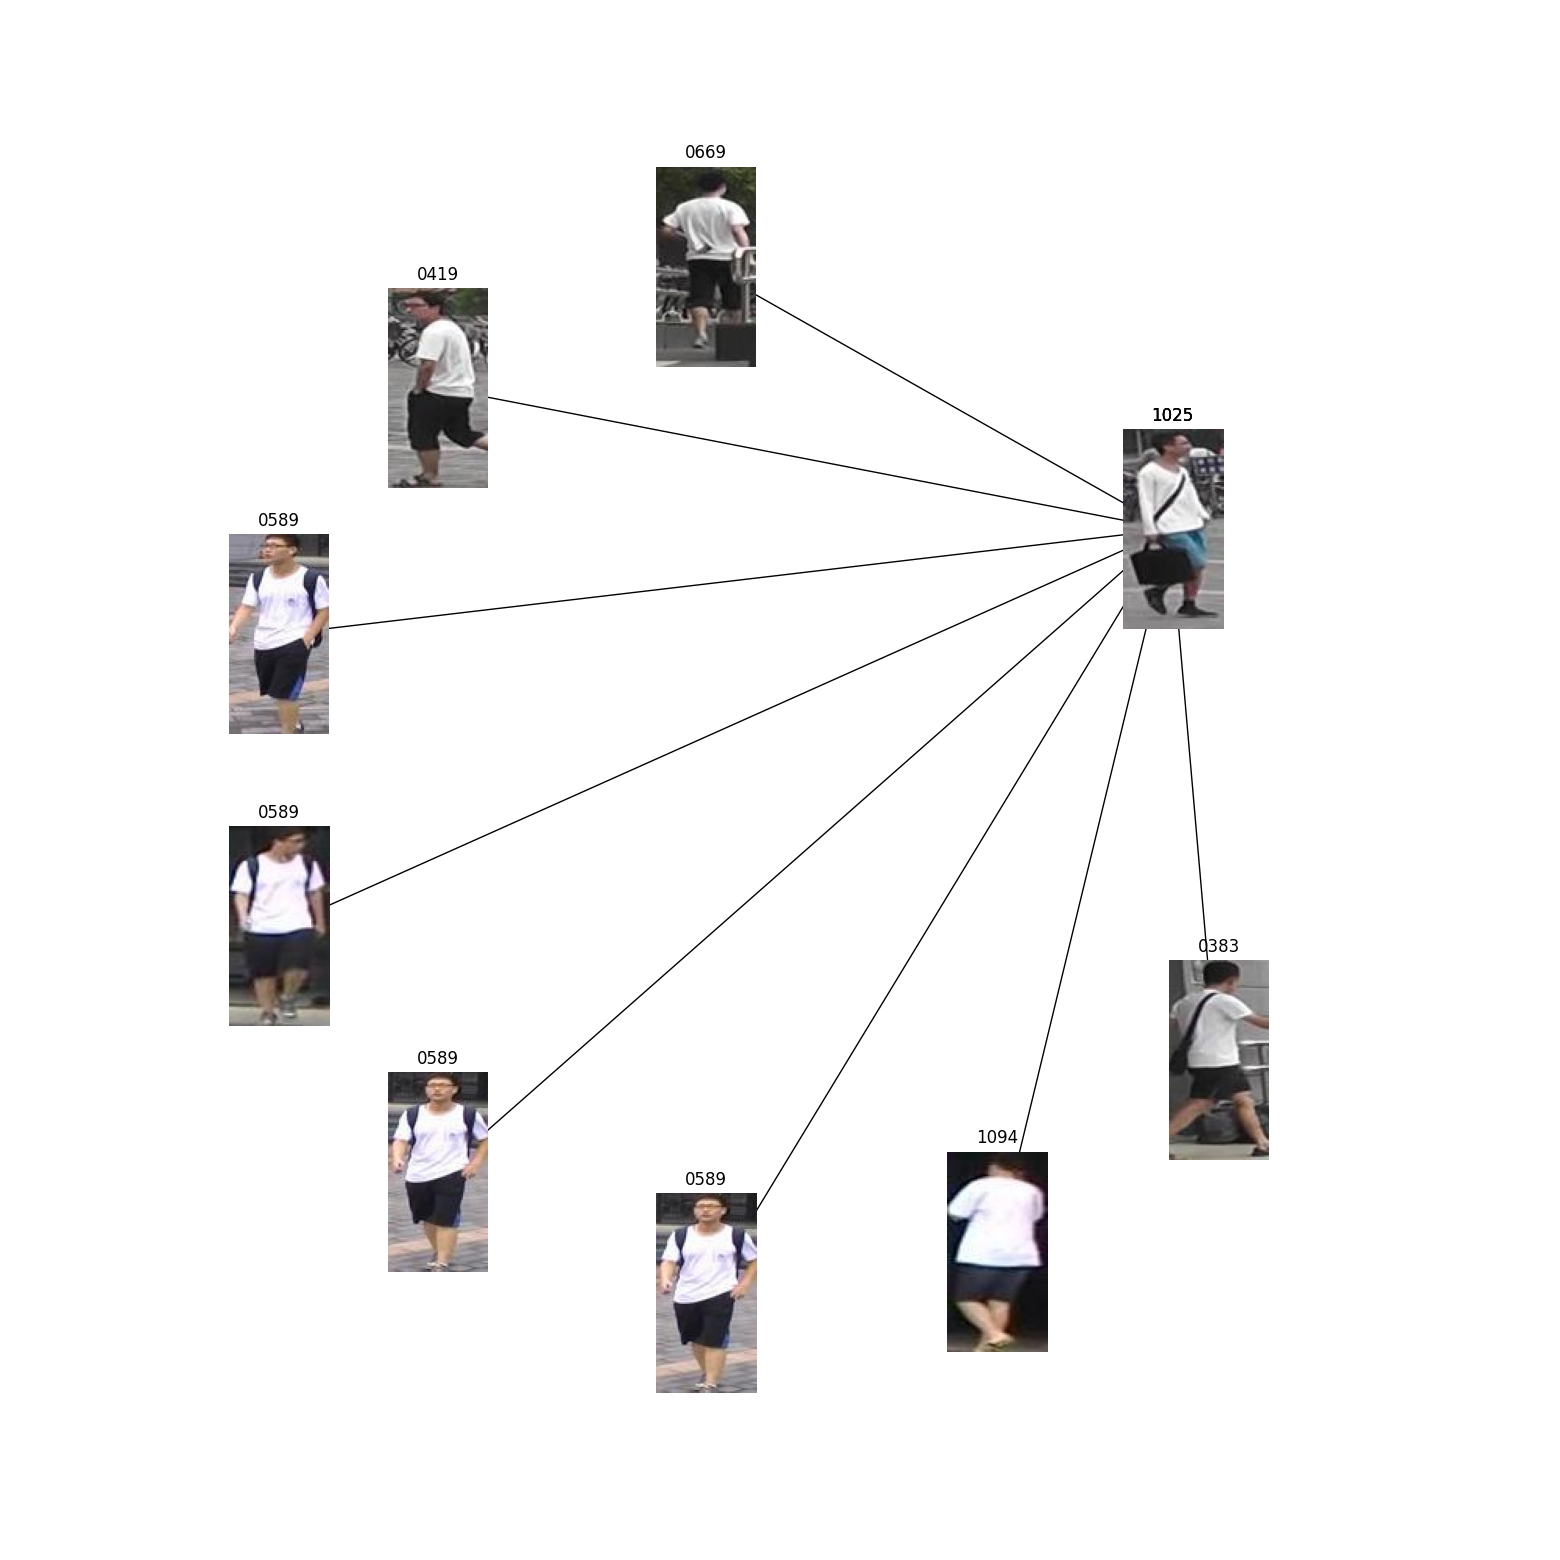

In [50]:
result = process_image(26, df_enc, model, data_dir)
anc_img_names, data_dir, img, img_path, closest_idx, distance = result
plot_closest_imgs(anc_img_names, data_dir, img_path, closest_idx, distance, no_of_closest=10)
